In [1]:
import logging
import os
import pickle

import pandas

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM
from keras.layers import ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import isolearn.keras

Using TensorFlow backend.


In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120

In [3]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Load data

In [2]:
# Load 5'UTR data
data = pandas.read_csv('../../polysome_profiling_data/GSE232927_processed_random_end_hek293t_N25_combined.csv.gz')

# Preserve only sequences with largest number of reads
data = data[data['total'] > 500]

# Extract data on the 10th highest percentile
data_high_mrl = data.sort_values('rl', ascending=False)
data_high_mrl = data_high_mrl.iloc[:10000]

# Sample to get training and test datasets
data_high_mrl = data_high_mrl.sample(frac=1, axis=0)

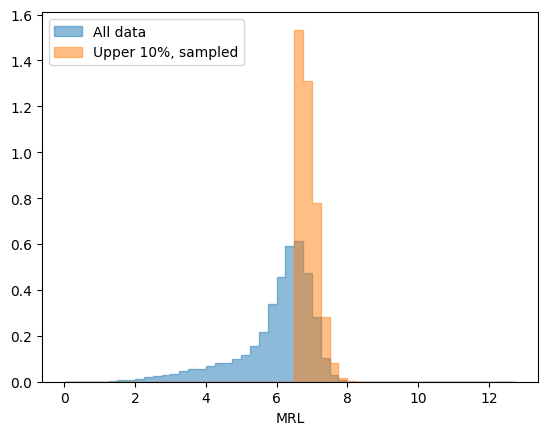

In [3]:
# MRL histogram of all and sampled data
bins=np.arange(0, 13, 0.25)
plt.hist(
    data['rl'],
    bins=bins,
    density=True,
    histtype='stepfilled',
    edgecolor='tab:blue',
    alpha = 0.5,
    color= 'tab:blue',
    label='All data',
)
plt.hist(
    data_high_mrl['rl'],
    bins=bins,
    density=True,
    histtype='stepfilled',
    edgecolor='tab:orange',
    alpha = 0.5,
    color= 'tab:orange',
    label='Upper 10%, sampled',
)
plt.xlabel("MRL")
plt.legend(loc='upper left')

In [9]:
# Extract sequences, encode as one-hot
data_train = data_high_mrl.iloc[:5000]
data_test = data_high_mrl.iloc[5000:6000]

seqs_train = data_train['UTR'].values.tolist()
seqs_test = data_test['UTR'].values.tolist()

encoder = isolearn.keras.OneHotEncoder(seq_length=25)

x_train = np.concatenate(
    [np.expand_dims(np.expand_dims(encoder(seq), axis=0), axis=0)
     for seq in seqs_train],
    axis=0,
)
x_test = np.concatenate(
    [np.expand_dims(np.expand_dims(encoder(seq), axis=0), axis=0)
     for seq in seqs_test],
    axis=0,
)

# Define VAE

## Encoder definitions

In [10]:
def build_disc_resblock(
        n_channels=64,
        window_size=8,
        dilation_rate=1,
        group_ix=0,
        layer_ix=0):
    '''Return a function that computes an encoder residual block'''

    batch_norm_0 = BatchNormalization(
        name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0',
    )

    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_0 = Conv2D(
        filters=n_channels,
        kernel_size=(1, window_size),
        dilation_rate=dilation_rate,
        strides=(1, 1),
        padding='same',
        activation='linear',
        kernel_initializer='glorot_normal',
        name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_0',
    )

    batch_norm_1 = BatchNormalization(
        name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1',
    )

    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_1 = Conv2D(
        filters=n_channels,
        kernel_size=(1, window_size),
        dilation_rate=dilation_rate,
        strides=(1, 1),
        padding='same',
        activation='linear',
        kernel_initializer='glorot_normal',
        name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1',
    )

    skip_1 = Lambda(
        lambda x: x[0] + x[1],
        name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1',
    )

    def _resblock_func(input_tensor) :
        '''Compute an encoder residual block'''
        batch_norm_0_out = batch_norm_0(input_tensor)
        relu_0_out = relu_0(batch_norm_0_out)
        conv_0_out = conv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(conv_0_out)
        relu_1_out = relu_1(batch_norm_1_out)
        conv_1_out = conv_1(relu_1_out)

        skip_1_out = skip_1([conv_1_out, input_tensor])
        
        return skip_1_out

    return _resblock_func

In [11]:
def build_encoder_4_resblock_func(
        batch_size,
        seq_length=50,
        latent_size=100,
        drop_rate=0.25):
    '''Return a function that computes a 4-resblock VAE encoder'''

    #Discriminator network parameters
    n_resblocks = 4
    n_channels = 32

    #Discriminator network definition
    policy_conv_0 = Conv2D(
        n_channels,
        (1, 1),
        strides=(1, 1),
        padding='same',
        activation='linear',
        kernel_initializer='glorot_normal',
        name='policy_discriminator_conv_0',
    )
    
    skip_conv_0 = Conv2D(
        filters=n_channels,
        kernel_size=(1, 1),
        strides=(1, 1),
        padding='same',
        activation='linear',
        kernel_initializer='glorot_normal',
        name='policy_discriminator_skip_conv_0',
    )
    
    resblocks = []
    for layer_ix in range(n_resblocks) :
        resblocks.append(
            build_disc_resblock(
                n_channels=n_channels,
                window_size=8,
                dilation_rate=1,
                group_ix=0,
                layer_ix=layer_ix,
            ),
        )
    
    last_block_conv = Conv2D(
        filters=n_channels,
        kernel_size=(1, 1),
        strides=(1, 1),
        padding='same',
        activation='linear',
        kernel_initializer='glorot_normal',
        name='policy_discriminator_last_block_conv',
    )
    
    skip_add = Lambda(lambda x: x[0] + x[1], name='policy_discriminator_skip_add')
    
    final_flatten = Flatten()
    
    z_mean = Dense(latent_size, name='policy_discriminator_z_mean')
    z_log_var = Dense(latent_size, name='policy_discriminator_z_log_var')
    
    def _encoder_func(sequence_input):
        '''Compute a 4-resblock VAE encoder'''
        policy_conv_0_out = policy_conv_0(sequence_input)

        # Connect group of res blocks
        output_tensor = policy_conv_0_out

        skip_conv_0_out = skip_conv_0(output_tensor)

        for layer_ix in range(n_resblocks) :
            output_tensor = resblocks[layer_ix](output_tensor)
        
        # Last res block extra convolution
        last_block_conv_out = last_block_conv(output_tensor)

        skip_add_out = skip_add([last_block_conv_out, skip_conv_0_out])

        # Final dense out
        final_dense_out = final_flatten(skip_add_out)
        
        # Z mean and log variance
        z_mean_out = z_mean(final_dense_out)
        z_log_var_out = z_log_var(final_dense_out)

        return z_mean_out, z_log_var_out

    return _encoder_func

In [12]:
def build_encoder_8_resblock_func(
        batch_size,
        seq_length=50,
        latent_size=100,
        drop_rate=0.25):
    '''Return a function that computes a 8-resblock VAE encoder'''

    #Discriminator network parameters
    n_resblocks = 4
    n_channels = 32

    #Discriminator network definition
    policy_conv_0 = Conv2D(
        filters=n_channels,
        kernel_size=(1, 1),
        strides=(1, 1),
        padding='same',
        activation='linear',
        kernel_initializer='glorot_normal',
        name='policy_discriminator_conv_0',
    )
    
    #Res block group 0
    skip_conv_0 = Conv2D(
        filters=n_channels,
        kernel_size=(1, 1),
        strides=(1, 1),
        padding='same',
        activation='linear',
        kernel_initializer='glorot_normal',
        name='policy_discriminator_skip_conv_0',
    )
    
    resblocks_0 = []
    for layer_ix in range(n_resblocks) :
        resblocks_0.append(
            build_disc_resblock(
                n_channels=n_channels,
                window_size=8,
                dilation_rate=1,
                group_ix=0,
                layer_ix=layer_ix,
            ),
        )
    
    #Res block group 1
    skip_conv_1 = Conv2D(
        filters=n_channels,
        kernel_size=(1, 1),
        strides=(1, 1),
        padding='same',
        activation='linear',
        kernel_initializer='glorot_normal',
        name='policy_discriminator_skip_conv_1',
    )
    
    resblocks_1 = []
    for layer_ix in range(n_resblocks) :
        resblocks_1.append(
            build_disc_resblock(
                n_channels=n_channels,
                window_size=8,
                dilation_rate=4,
                group_ix=1,
                layer_ix=layer_ix,
            ),
        )
    
    last_block_conv = Conv2D(
        filters=n_channels,
        kernel_size=(1, 1),
        strides=(1, 1),
        padding='same',
        activation='linear',
        kernel_initializer='glorot_normal',
        name='policy_discriminator_last_block_conv',
    )
    
    skip_add = Lambda(lambda x: x[0] + x[1] + x[2], name='policy_discriminator_skip_add')
    
    final_flatten = Flatten()
    
    z_mean = Dense(latent_size, name='policy_discriminator_z_mean')
    z_log_var = Dense(latent_size, name='policy_discriminator_z_log_var')
    
    def _encoder_func(sequence_input):
        '''Compute a 8-resblock VAE encoder'''
        policy_conv_0_out = policy_conv_0(sequence_input)

        # Connect group of res blocks
        output_tensor = policy_conv_0_out

        # Res block group 0
        skip_conv_0_out = skip_conv_0(output_tensor)

        for layer_ix in range(n_resblocks) :
            output_tensor = resblocks_0[layer_ix](output_tensor)
        
        # Res block group 1
        skip_conv_1_out = skip_conv_1(output_tensor)

        for layer_ix in range(n_resblocks) :
            output_tensor = resblocks_1[layer_ix](output_tensor)
        
        # Last res block extra convolution
        last_block_conv_out = last_block_conv(output_tensor)

        skip_add_out = skip_add([last_block_conv_out, skip_conv_0_out, skip_conv_1_out])

        # Final dense out
        final_dense_out = final_flatten(skip_add_out)
        
        # Z mean and log variance
        z_mean_out = z_mean(final_dense_out)
        z_log_var_out = z_log_var(final_dense_out)

        return z_mean_out, z_log_var_out

    return _encoder_func

## Middle sampler definitions

In [13]:
def get_z_sample(z_inputs):
    '''
    Sample from normal given by inputs
    
    Parameters
    ----------
    z_inputs : 2-element list
        List containing tensors z_mean and z_log_var, each
        with size (batch_size, latent_dim).
        
    Returns
    -------
    tensor of size (batch_size, latent_dim)
        Sampled vectors.
    
    '''
    # Extract inputs
    z_mean, z_log_var = z_inputs
    
    # Extract dimensions
    batch_size = K.shape(z_mean)[0]
    latent_dim = K.int_shape(z_mean)[1]
    
    # Sample from N(0, 1)
    epsilon = K.random_normal(shape=(batch_size, latent_dim))
    
    # Return normals with proper mean and var
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

## Decoder definitions

In [14]:
def build_gen_resblock(
        n_channels=64,
        window_size=3,
        stride=1,
        dilation=1,
        group_ix=0,
        layer_ix=0):
    '''Return a function that computes a decoder residual block'''

    #Initialize res block layers
    batch_norm_0 = BatchNormalization(
        name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0',
    )

    relu_0 = Lambda(lambda x: K.relu(x))
    
    deconv_0 = Conv2DTranspose(
        filters=n_channels,
        kernel_size=(1, window_size),
        strides=(1, stride),
        padding='same',
        activation='linear',
        kernel_initializer='glorot_uniform',
        name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_deconv_0',
    )

    batch_norm_1 = BatchNormalization(
        name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1',
    )

    relu_1 = Lambda(lambda x: K.relu(x))

    conv_1 = Conv2D(
        filters=n_channels,
        kernel_size=(1, window_size),
        dilation_rate=(1, dilation),
        strides=(1, 1),
        padding='same',
        activation='linear',
        kernel_initializer='glorot_uniform',
        name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1',
    )

    skip_deconv_0 = Conv2DTranspose(
        filters=n_channels,
        kernel_size=(1, 1),
        strides=(1, stride),
        padding='same',
        activation='linear',
        kernel_initializer='glorot_uniform',
        name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_deconv_0',
    )
    
    skip_1 = Lambda(
        lambda x: x[0] + x[1],
        name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1',
    )

    #Execute res block
    def _resblock_func(input_tensor):
        '''Computes a decoder residual block'''
        
        batch_norm_0_out = batch_norm_0(input_tensor)
        relu_0_out = relu_0(batch_norm_0_out)
        deconv_0_out = deconv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(deconv_0_out)
        relu_1_out = relu_1(batch_norm_1_out)
        conv_1_out = conv_1(relu_1_out)
        
        skip_deconv_0_out = skip_deconv_0(input_tensor)

        skip_1_out = skip_1([conv_1_out, skip_deconv_0_out])
        
        return skip_1_out

    return _resblock_func

In [15]:
def build_decoder_func(seq_length=50, latent_size=100):
    '''Return a function that computes the VAE decoder'''

    # Generator network parameters
    window_size = 3
    
    strides = [2, 2, 2, 2, 1]
    dilations = [1, 1, 1, 1, 1]
    channels = [256, 128, 96, 64, 32]
    initial_length = 4
    n_resblocks = len(strides)

    # Policy network definition
    policy_dense_0 = Dense(
        initial_length * channels[0],
        activation='linear',
        kernel_initializer='glorot_uniform',
        name='policy_generator_dense_0',
    )
    policy_dense_0_reshape = Reshape((1, initial_length, channels[0]))
    
    curr_length = initial_length
    
    resblocks = []
    for layer_ix in range(n_resblocks) :
        resblocks.append(
            build_gen_resblock(
                n_channels=channels[layer_ix],
                window_size=window_size,
                stride=strides[layer_ix],
                dilation=dilations[layer_ix],
                group_ix=0,
                layer_ix=layer_ix,
            ),
        )
    
    final_conv = Conv2D(
        filters=4,
        kernel_size=(1, 1),
        strides=(1, 1),
        padding='same',
        activation='linear',
        kernel_initializer='glorot_uniform',
        name='policy_generator_final_conv')
    
    final_slice = Lambda(lambda x, seq_length=seq_length: x[:, :, :seq_length, :])
    
    def _decoder_func(seed_input) :
        '''Compute the VAE decoder'''
        policy_dense_0_out = policy_dense_0(seed_input)
        policy_dense_0_out = policy_dense_0_reshape(policy_dense_0_out)
        
        # Connect group of res blocks
        output_tensor = policy_dense_0_out

        for layer_ix in range(n_resblocks) :
            output_tensor = resblocks[layer_ix](output_tensor)

        # Final conv out
        final_conv_out = final_conv(output_tensor)
        
        return final_slice(final_conv_out)

    return _decoder_func

## Final sampler definitions

In [16]:
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/beyond-binary-ternary-and-one-hot-neurons.html
#See Github https://github.com/spitis/

def st_sampled_softmax(logits):
    '''
    Sample from multinomial distribution given by provided logits.
    
    Parameters
    ----------
    logits : tensor of size (n_positions, n_dim)
        Logits for each position.
        
    Returns
    -------
    tensor of size (n_positions, n_dim)
        Sampled elements, one-hot encoded.
    '''
    with ops.name_scope("STSampledSoftmax") as namescope:
        # Obtain probabilities from logits
        nt_probs = tf.nn.softmax(logits)
        # Sample from logits
        sampled_indices = tf.multinomial(
            logits=logits,
            num_samples=1,
        )
        sampled_indices = tf.squeeze(sampled_indices, axis=1)
        # Transform samples to one-hot
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(
            indices=sampled_indices,
            depth=onehot_dim,
            on_value=1.0,
            off_value=0.0,
        )
        # ???
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

def st_hardmax_softmax(logits):
    '''
    Obtain sample form the max provided logit per position.
    
    Parameters
    ----------
    logits : tensor of size (n_positions, n_dim)
        Logits for each position.
        
    Returns
    -------
    tensor of size (n_positions, n_dim)
        Sampled elements, one-hot encoded.
    '''
    with ops.name_scope("STHardmaxSoftmax") as namescope:
        # Obtain probabilities from logits
        nt_probs = tf.nn.softmax(logits)
        # Sample from logits
        sampled_indices = tf.argmax(nt_probs, 1)
        # Transform samples to one-hot
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(
            indices=sampled_indices,
            depth=onehot_dim,
            on_value=1.0,
            off_value=0.0,
        )
        # ???
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

@ops.RegisterGradient("STMul")
def st_mul(op, grad):
    return [grad, grad]

In [17]:
def sample_pwm_softmax(pwm_logits):
    '''
    Sample from multinomial distribution given by provided logits.
    
    Parameters
    ----------
    pwm_logits : tensor of size (n_sequences, 1, seq_length, 4)
        Logits for each sequence and base.
        
    Returns
    -------
    tensor of size (n_sequences, 1, seq_length, 4)
        Sampled sequences, one-hot encoded.
    '''
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 4))
    sampled_pwm = st_sampled_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 4))

def sample_pwm_hardmax(pwm_logits):
    '''
    Obtain sequences from the max logit per position.
    
    Parameters
    ----------
    pwm_logits : tensor of size (n_sequences, 1, seq_length, 4)
        Logits for each sequence and base.
        
    Returns
    -------
    tensor of size (n_sequences, 1, seq_length, 4)
        Sampled sequences, one-hot encoded.
    '''
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 4))
    sampled_pwm = st_hardmax_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 4))

def sample_pwm(pwm_logits):
    '''
    Sample from provided logits depending on training phase.
    
    Sample from a multinomial distribution during training,
    and use the max logit per position during testing.
    
    Parameters
    ----------
    pwm_logits : tensor of size (n_sequences, 1, seq_length, 4)
        Logits for each sequence and base.
        
    Returns
    -------
    tensor of size (n_sequences, 1, seq_length, 4)
        Sampled sequences, one-hot encoded.
    '''
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 4))
    sampled_pwm = K.switch(
        K.learning_phase(),
        st_sampled_softmax(flat_pwm),
        st_hardmax_softmax(flat_pwm),
    )

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 4))

In [18]:
# PWM Masking helper function
def mask_pwm(inputs):
    pwm, onehot_template, onehot_mask = inputs

    return pwm * onehot_mask + onehot_template

In [19]:
def build_sampler_func(
        batch_size,
        seq_length,
        n_classes=1,
        n_samples=None,
        validation_sample_mode='max'):
    '''Return a function that computes the VAE sampler'''

    
    use_samples = True
    if n_samples is None:
        use_samples = False
        n_samples = 1

    # Initialize template and mask matrices
    onehot_template_dense = Embedding(
        input_dim=n_classes,
        output_dim=seq_length * 4,
        embeddings_initializer='zeros',
        name='template_dense',
    )
    onehot_mask_dense = Embedding(
        input_dim=n_classes,
        output_dim=seq_length * 4,
        embeddings_initializer='ones',
        name='mask_dense',
    )
    
    # Initialize Reshape layer
    # To be used on the template and mask tensors
    reshape_layer = Reshape((1, seq_length, 4))

    # Initialize Templating and Masking Lambda layer
    masking_layer = Lambda(
        mask_pwm,
        output_shape=(1, seq_length, 4),
        name='masking_layer',
    )
    
    # Initialize PWM normalization layer
    pwm_layer = Softmax(axis=-1, name='pwm')
    
    # Initialize sampling layer
    if validation_sample_mode == 'sample':
        sample_func = sample_pwm_softmax
    else:
        sample_func = sample_pwm

    sampling_layer = Lambda(
        sample_func,
        name='pwm_sampler')
    
    # Initialize upsampling layer
    # Repeats the elements of a tensor along the batch dimension
    # Output shape is (n_samples*batch_size, 1, seq_length, 4)
    upsampling_layer = Lambda(
        lambda x: K.tile(x, [n_samples, 1, 1, 1]),
        name='upsampling_layer')
    
    # Initialize permute layer
    # This layer manipulates an input tensor of shape
    # (n_samples*batch_size, 1, seq_length, 4) and returns one with
    # shape (batch_size, n_samples, 1, seq_length, 4)
    permute_layer = Lambda(
        lambda x: K.permute_dimensions(
            K.reshape(x, (n_samples, batch_size, 1, seq_length, 4)),
            (1, 0, 2, 3, 4),
        ),
        name='permute_layer')
    

    def _sampler_func(class_input, raw_logits):
        '''Compute the VAE sampler'''
        
        #Get Template and Mask
        onehot_template = reshape_layer(onehot_template_dense(class_input))
        onehot_mask = reshape_layer(onehot_mask_dense(class_input))
        
        #Add Template and Multiply Mask
        pwm_logits = masking_layer([raw_logits, onehot_template, onehot_mask])
        
        #Compute PWM (Nucleotide-wise Softmax)
        pwm = pwm_layer(pwm_logits)
        
        sampled_pwm = None
        
        # Optionally tile PWMs and sample
        if use_samples:
            pwm_logits_upsampled = upsampling_layer(pwm_logits)
            sampled_pwm = sampling_layer(pwm_logits_upsampled)
            sampled_pwm = permute_layer(sampled_pwm)
        else:
            sampled_pwm = sampling_layer(pwm_logits)

        return pwm_logits, pwm, sampled_pwm
    
    return _sampler_func

## Helper loss functions

In [20]:
def build_pwm_cross_entropy_func(pwm_start, pwm_end):
    '''Return function computing PWM CE between specified positions'''

    def _pwm_cross_entropy_func(inputs):
        # PWMs have dimensions (batch_size, 1, seq_length, 4)
        pwm_true, pwm_pred = inputs
        
        pwm_pred = K.clip(pwm_pred, K.epsilon(), 1. - K.epsilon())

        # Cross-entropy, -pwm_true*log(pwm_pred), sum over bases axis
        # Dimensions are (batch_size, 1, seq_length)
        ce = - K.sum(pwm_true[:, 0, pwm_start:pwm_end, :] * \
                     K.log(pwm_pred[:, 0, pwm_start:pwm_end, :]), axis=-1)
        
        # Return mean CE, dimensions are (batch_size, 1, 1)
        return K.expand_dims(K.mean(ce, axis=-1), axis=-1)
    
    return _pwm_cross_entropy_func

def build_weighted_dummy_loss_func(loss_coeff=1.):
    '''Return weighted dummy loss function'''
    
    def _weighted_dummy_loss_func(y_true, y_pred):
        return loss_coeff * y_pred
    
    return _weighted_dummy_loss_func

def build_z_kl_loss_func(anneal_coeff):
    '''Return KL loss function for z values, annealed'''
    
    def _z_kl_loss_func(inputs, anneal_coeff=anneal_coeff) :
        z_mean, z_log_var = inputs
        
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.mean(kl_loss, axis=-1)
        kl_loss *= -0.5
        
        return anneal_coeff * K.expand_dims(kl_loss, axis=-1)
    
    return _z_kl_loss_func

In [21]:
def min_pred(y_true, y_pred) :
    return y_pred

## Model definitions

In [22]:
#Generator helper functions
def initialize_sequence_templates(generator, sequence_templates) :
    '''Populates the template and mask layers of a generator'''
    
    embedding_templates = []
    embedding_masks = []

    for k in range(len(sequence_templates)) :
        sequence_template = sequence_templates[k]
        
        # Encode template as one-hot
        onehot_encoder = isolearn.keras.OneHotEncoder(seq_length=len(sequence_template))
        onehot_template = onehot_encoder(sequence_template)
        onehot_template = onehot_template.reshape((1, len(sequence_template), 4))

        # Modify one-hot template values based on template
        # ACTG base position: 10
        # ACTG non-base position: -4
        # N: 0
        # X: -1
        for j in range(len(sequence_template)) :
            if sequence_template[j] not in ['N', 'X'] :
                nt_ix = np.argmax(onehot_template[0, j, :])
                onehot_template[:, j, :] = -4.0
                onehot_template[:, j, nt_ix] = 10.0
            elif sequence_template[j] == 'X' :
                onehot_template[:, j, :] = -1.0

        # Encode mask based on template
        # Positions with N: all ones, otherwise zero
        onehot_mask = np.zeros((1, len(sequence_template), 4))
        for j in range(len(sequence_template)) :
            if sequence_template[j] == 'N' :
                onehot_mask[:, j, :] = 1.0

        # Reshape to (1, sequence_length*4)
        embedding_template = onehot_template.reshape(1, -1)
        embedding_mask = onehot_mask.reshape(1, -1)
        
        embedding_templates.append(embedding_template)
        embedding_masks.append(embedding_mask)

    # Concatename embedding vectors
    # Dimensions after this are (n_templates, sequence_length*4)
    embedding_templates = np.concatenate(embedding_templates, axis=0)
    embedding_masks = np.concatenate(embedding_masks, axis=0)

    # Set weight values, non-trainable
    generator.get_layer('template_dense').set_weights([embedding_templates])
    generator.get_layer('template_dense').trainable = False

    generator.get_layer('mask_dense').set_weights([embedding_masks])
    generator.get_layer('mask_dense').trainable = False

In [23]:
# Initialize Encoder and Decoder networks
sequence_templates = ['N' * 25]
seq_length = len(sequence_templates[0])
batch_size = 32
n_samples = None
latent_size = 100

# Load Encoder
encoder_func = build_encoder_4_resblock_func(
    batch_size=batch_size,
    seq_length=seq_length,
    latent_size=latent_size,
    drop_rate=0.)

# Load Decoder
decoder_func = build_decoder_func(
    seq_length=seq_length,
    latent_size=latent_size)

# Load Sampler
sampler_func = build_sampler_func(
    batch_size=batch_size,
    seq_length=seq_length,
    n_classes=1,
    n_samples=n_samples,
    validation_sample_mode='sample')

In [24]:
# Build Encoder Model

encoder_input = Input(shape=(1, seq_length, 4), name='encoder_input')

# Encoder
z_mean, z_log_var = encoder_func(encoder_input)

# Intermediate sampler
z_sampling_layer = Lambda(get_z_sample, output_shape=(latent_size,), name='z_sampler')
z = z_sampling_layer([z_mean, z_log_var])

# Build and compile model
encoder_model = Model(encoder_input, [z_mean, z_log_var, z])
encoder_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss=min_pred
)

In [25]:
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 1, 25, 4)     0                                            
__________________________________________________________________________________________________
policy_discriminator_conv_0 (Co (None, 1, 25, 32)    160         encoder_input[0][0]              
__________________________________________________________________________________________________
policy_discriminator_resblock_0 (None, 1, 25, 32)    128         policy_discriminator_conv_0[0][0]
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1, 25, 32)    0           policy_discriminator_resblock_0_0
__________________________________________________________________________________________________
policy_dis

In [26]:
# Build Decoder Model

decoder_class = Input(shape=(1,), name='decoder_class')
decoder_input = Input(shape=(latent_size,), name='decoder_input')

# Decoder
decoder_output = decoder_func(decoder_input)
# Output sampler
pwm_logits, pwm, sampled_pwm = sampler_func(decoder_class, decoder_output)

# Build model
decoder_model = Model([decoder_class, decoder_input], [pwm_logits, pwm, sampled_pwm])

# Initialize sequence templates and masks
initialize_sequence_templates(decoder_model, sequence_templates)

# Compile
decoder_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss=min_pred
)

In [27]:
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, 100)          0                                            
__________________________________________________________________________________________________
policy_generator_dense_0 (Dense (None, 1024)         103424      decoder_input[0][0]              
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 4, 256)    0           policy_generator_dense_0[0][0]   
__________________________________________________________________________________________________
policy_generator_resblock_0_0_b (None, 1, 4, 256)    1024        reshape_1[0][0]                  
__________________________________________________________________________________________________
lambda_9 (

In [28]:
# Build VAE Model

vae_decoder_class = Input(shape=(1,), name='vae_decoder_class')
vae_encoder_input = Input(shape=(1, seq_length, 4), name='vae_encoder_input')

# Build network
encoded_z_mean, encoded_z_log_var = encoder_func(vae_encoder_input)
encoded_z = z_sampling_layer([encoded_z_mean, encoded_z_log_var])
decoder_output = decoder_func(encoded_z)
decoded_logits, decoded_pwm, decoded_sample = sampler_func(vae_decoder_class, decoder_output)

# Build loss layers
reconstruction_loss_layer = Lambda(
    build_pwm_cross_entropy_func(pwm_start=0, pwm_end=seq_length),
    name='reconstruction')
reconstruction_loss = reconstruction_loss_layer([vae_encoder_input, decoded_pwm])

anneal_coeff = K.variable(0.0)

kl_loss_layer = Lambda(build_z_kl_loss_func(anneal_coeff), name='kl')
kl_loss = kl_loss_layer([encoded_z_mean, encoded_z_log_var])

# Build model
vae_model = Model(
    [vae_decoder_class, vae_encoder_input],
    [reconstruction_loss, kl_loss]
)

# Initialize sequence templates and masks
initialize_sequence_templates(vae_model, sequence_templates)

# Compile
kl_loss_coeff = 2.35
vae_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss={
        'reconstruction' : build_weighted_dummy_loss_func(loss_coeff=1.),
        'kl' : build_weighted_dummy_loss_func(loss_coeff=kl_loss_coeff)
    }
)


In [29]:
# Annealing function and callback

def _anneal_func(val, epoch):
    if epoch <= 0 :
        return 0.0
    elif epoch <= 3 :
        return 0.1
    elif epoch <= 6 :
        return 0.2
    elif epoch <= 9 :
        return 0.4
    elif epoch <= 12 :
        return 0.6
    elif epoch <= 15 :
        return 0.8
    elif epoch > 15 :
        return 1.0
    return 1.0

class EpochVariableCallback(Callback):
    def __init__(self, my_variable, my_func):
        self.my_variable = my_variable       
        self.my_func = my_func
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))
        
annealing_callback = EpochVariableCallback(anneal_coeff, _anneal_func)

In [30]:
# Train model
n_epochs = 50

class_train = np.zeros((x_train.shape[0], 1))
class_test = np.zeros((x_test.shape[0], 1))

dummy_target_train = np.zeros((x_train.shape[0], 1))
dummy_target_test = np.zeros((x_test.shape[0], 1))

# callbacks =[
# #     ModelCheckpoint(
# #         "model_checkpoints/" + model_name + "_epoch_{epoch:02d}.hdf5",
# #         monitor='val_loss',
# #         mode='min',
# #         save_weights_only=True,
# #         period=5,
# #     ),
#     annealing_callback
# ]

train_history = vae_model.fit(
    x=[class_train, x_train],
    y=[dummy_target_train, dummy_target_train],#, dummy_target_train],
    shuffle=True,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(
        [class_test, x_test],
        [dummy_target_test, dummy_target_test]#, dummy_target_test]
    ),
    callbacks=[annealing_callback]
)


Train on 5000 samples, validate on 1000 samples
Epoch 1/50
5000/5000 [==============================] - 12s 2ms/step - loss: 1.4233 - reconstruction_loss: 1.4233 - kl_loss: 0.0000e+00 - val_loss: 1.1238 - val_reconstruction_loss: 1.1238 - val_kl_loss: 0.0000e+00
Epoch 2/50
5000/5000 [==============================] - 3s 698us/step - loss: 0.8291 - reconstruction_loss: 0.8291 - kl_loss: 0.0000e+00 - val_loss: 0.6859 - val_reconstruction_loss: 0.6859 - val_kl_loss: 0.0000e+00
Epoch 3/50
5000/5000 [==============================] - 3s 695us/step - loss: 1.2234 - reconstruction_loss: 0.6775 - kl_loss: 0.5459 - val_loss: 1.1032 - val_reconstruction_loss: 0.7368 - val_kl_loss: 0.3664
Epoch 4/50
5000/5000 [==============================] - 4s 715us/step - loss: 0.8814 - reconstruction_loss: 0.5213 - kl_loss: 0.3601 - val_loss: 0.8674 - val_reconstruction_loss: 0.5302 - val_kl_loss: 0.3372
Epoch 5/50
5000/5000 [==============================] - 4s 703us/step - loss: 0.7019 - reconstruction_los

Epoch 40/50
5000/5000 [==============================] - 3s 694us/step - loss: 1.1339 - reconstruction_loss: 0.5078 - kl_loss: 0.6261 - val_loss: 1.1642 - val_reconstruction_loss: 0.5289 - val_kl_loss: 0.6353
Epoch 41/50
5000/5000 [==============================] - 3s 693us/step - loss: 1.1345 - reconstruction_loss: 0.5072 - kl_loss: 0.6273 - val_loss: 1.1663 - val_reconstruction_loss: 0.5445 - val_kl_loss: 0.6218
Epoch 42/50
5000/5000 [==============================] - 3s 694us/step - loss: 1.1305 - reconstruction_loss: 0.5028 - kl_loss: 0.6277 - val_loss: 1.1678 - val_reconstruction_loss: 0.5370 - val_kl_loss: 0.6308
Epoch 43/50
5000/5000 [==============================] - 3s 694us/step - loss: 1.1296 - reconstruction_loss: 0.5003 - kl_loss: 0.6293 - val_loss: 1.1677 - val_reconstruction_loss: 0.5322 - val_kl_loss: 0.6355
Epoch 44/50
5000/5000 [==============================] - 3s 693us/step - loss: 1.1264 - reconstruction_loss: 0.4951 - kl_loss: 0.6313 - val_loss: 1.1422 - val_recon

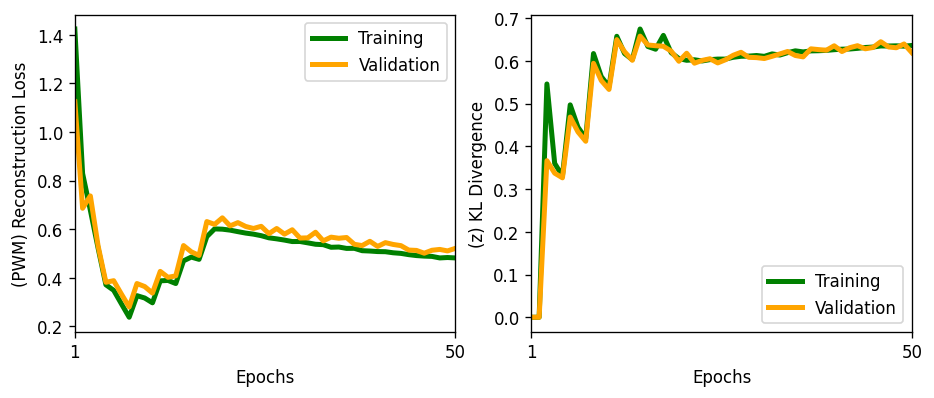

In [31]:
# Plot losses through training history
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3.5))

n_epochs_actual = len(train_history.history['reconstruction_loss'])

ax1.plot(
    np.arange(1, n_epochs_actual + 1),
    train_history.history['reconstruction_loss'],
    linewidth=3,
    color='green',
    label='Training',
)
ax1.plot(
    np.arange(1, n_epochs_actual + 1),
    train_history.history['val_reconstruction_loss'],
    linewidth=3,
    color='orange',
    label='Validation',
)

plt.sca(ax1)
plt.xlabel("Epochs")
plt.ylabel("(PWM) Reconstruction Loss")
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs])
plt.legend()

ax2.plot(
    np.arange(1, n_epochs_actual + 1),
    train_history.history['kl_loss'],
    linewidth=3,
    color='green',
    label='Training',
)
ax2.plot(
    np.arange(1, n_epochs_actual + 1),
    train_history.history['val_kl_loss'],
    linewidth=3,
    color='orange',
    label='Validation',
)

plt.sca(ax2)
plt.xlabel("Epochs")
plt.ylabel("(z) KL Divergence")
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs])
plt.legend()

In [32]:
# Save model and weights
# model_name = "vae_25bp_random_strong_n_epochs_{}_kl_weight_{}".format(n_epochs, int(kl_loss_coeff*100))
# model_name = "vae_25bp_random_strong_n_epochs_{}_kl_weight_{}_cyclic".format(n_epochs, int(kl_loss_coeff*100))
model_name = "vae_25bp_random_strong_n_epochs_{}_kl_weight_{}_readth_{}".format(
    n_epochs,
    int(kl_loss_coeff*100),
    500)
save_dir = 'saved_vae'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '_encoder.h5')
encoder_model.save(model_path)
print('Saved trained model at %s ' % model_path)

model_path = os.path.join(save_dir, model_name + '_decoder.h5')
decoder_model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at saved_vae/vae_50bp_defined_strong_n_epochs_50_kl_weight_235_readth_500_encoder.h5 
Saved trained model at saved_vae/vae_50bp_defined_strong_n_epochs_50_kl_weight_235_readth_500_decoder.h5 


# Evaluate trained model

In [46]:
# Load models
seq_length = 25
n_epochs = 50
kl_loss_coeff = 2.35
# model_name = "vae_optimus5_strong_len_25_latent_100_epochs_50_kl_factor_235_annealed_high_rc"
model_name = "vae_25bp_random_strong_n_epochs_{}_kl_weight_{}".format(n_epochs, int(kl_loss_coeff*100))
# model_name = "vae_25bp_random_strong_n_epochs_{}_kl_weight_{}_cyclic".format(n_epochs, int(kl_loss_coeff*100))
# model_name = "vae_25bp_random_strong_n_epochs_{}_kl_weight_{}_readth_500".format(n_epochs, int(kl_loss_coeff*100))
save_dir = 'saved_vae'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
custom_objects = {
    'st_sampled_softmax': st_sampled_softmax,
    'st_hardmax_softmax': st_hardmax_softmax,
    'min_pred': min_pred,
}

model_path = os.path.join(save_dir, model_name + '_encoder.h5')
encoder_model = load_model(model_path, custom_objects=custom_objects)

model_path = os.path.join(save_dir, model_name + '_decoder.h5')
decoder_model = load_model(model_path, custom_objects=custom_objects)

## Visualize test and artificial sequences

In [47]:
import logomaker

def plot_pwm(pwms, title=None):
    for pwm in pwms:
        # Calculate entropy and conservation
        entropy = np.zeros_like(pwm)
        entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(pwm[pwm > 0])
        entropy = np.sum(entropy, axis=1)
        conservation = 2 - entropy
        # Nucleotide height
        nt_height = np.tile(np.reshape(conservation, (-1, 1)), (1, 4))
        nt_height = pwm * nt_height
        
        nt_height_df = pd.DataFrame(
            nt_height,
            columns=['A', 'C', 'G', 'T'],
        )

        fig = plt.figure(figsize=(6, 0.4))
        ax = fig.add_subplot(1, 1, 1)
        logo = logomaker.Logo(
            nt_height_df,
            color_scheme='classic',
            ax=ax,
        )
        logo.style_spines(visible=False)
        logo.style_spines(spines=['bottom'], visible=True, linewidth=2)
        ax.set_xticks([])
        ax.set_yticks([])
        if title is not None:
            ax.set_title(title)

1000/1000 [==============================] - 1s 925us/step
Test sequence 0:


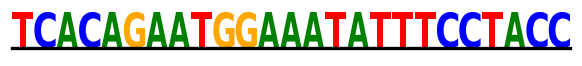

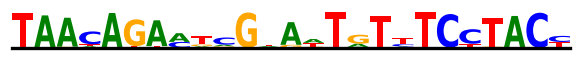

Test sequence 1:


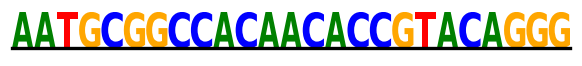

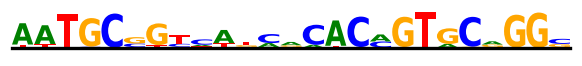

Test sequence 2:


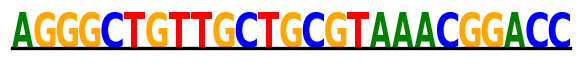

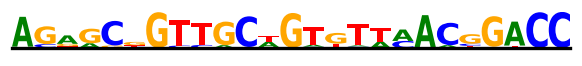

Test sequence 3:


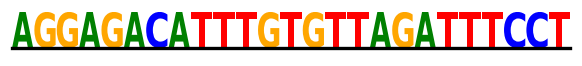

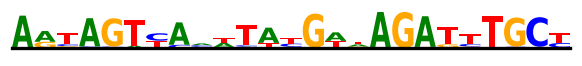

Test sequence 4:


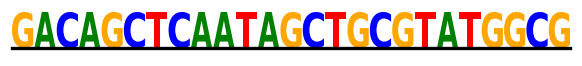

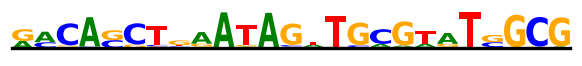

In [48]:
# Visualize some of the test data sequences

# Run encoder
z_mean_test, z_log_var_test, z_test = encoder_model.predict([x_test], batch_size=32, verbose=True)
# Run decoder
s_test = np.zeros((x_test.shape[0], 1))
fake_pwm_test_batch = decoder_model.predict([s_test, z_test], batch_size=32, verbose=True)

# Plot a few sequences
for plot_i in range(5):
    print("Test sequence " + str(plot_i) + ":")
    plot_pwm([x_test[plot_i, 0, :, :]])
    plot_pwm([fake_pwm_test_batch[1][plot_i, 0, :, :]])
    plt.show()

32/32 [==============================] - 0s 130us/step
Test sequence 0:


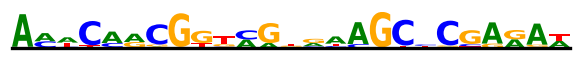

Test sequence 1:


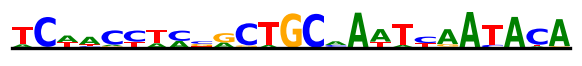

Test sequence 2:


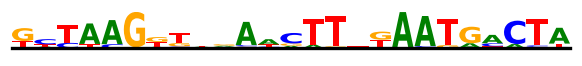

Test sequence 3:


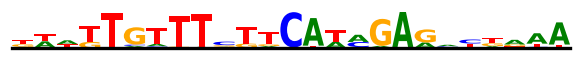

Test sequence 4:


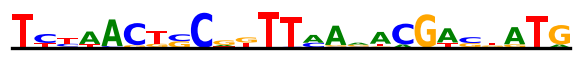

In [49]:
# Visualize a few random patterns
s_test = np.zeros((32, 1))
z_test = np.random.normal(size=(32, 100))

fake_pwm_test_batch = decoder_model.predict([s_test, z_test], batch_size=32, verbose=True)


for plot_i in range(5) :
    print("Test sequence " + str(plot_i) + ":")
    plot_pwm([fake_pwm_test_batch[1][plot_i, 0, :, :]])
    plt.show()

32/32 [==============================] - 0s 119us/step
Test sequence 0:


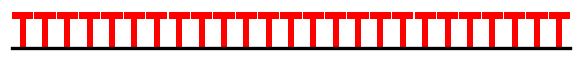

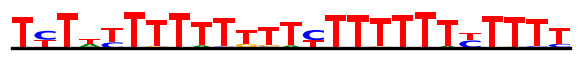

Test sequence 1:


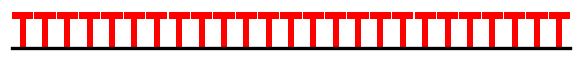

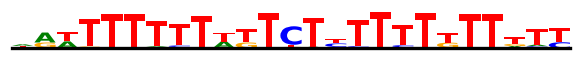

Test sequence 2:


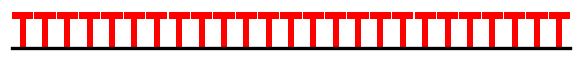

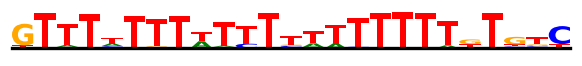

Test sequence 3:


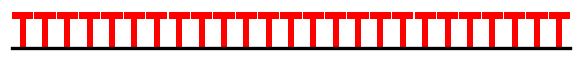

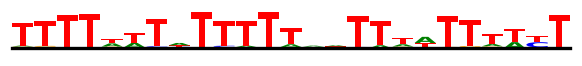

Test sequence 4:


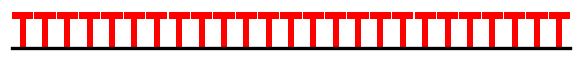

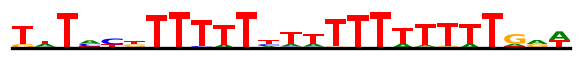

In [50]:
# Test sequences with stretches of Ts
x_a = np.zeros((32, 1, seq_length, 4))
x_a[:, :, :, 3] = 1.

# Run encoder
z_mean_test, z_log_var_test, z_test = encoder_model.predict([x_a], batch_size=32, verbose=True)
# Run decoder
s_test = np.zeros((x_a.shape[0], 1))
fake_pwm_test_batch = decoder_model.predict([s_test, z_test], batch_size=32, verbose=True)

# Plot a few sequences
for plot_i in range(5) :
    print("Test sequence " + str(plot_i) + ":")
    plot_pwm([x_a[plot_i, 0, :, :]])
    plot_pwm([fake_pwm_test_batch[1][plot_i, 0, :, :]])
    plt.show()

32/32 [==============================] - 0s 121us/step
Test sequence 0:


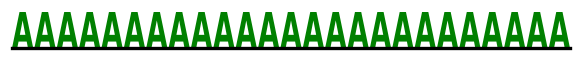

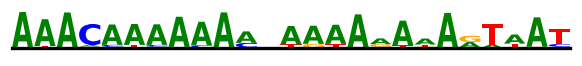

Test sequence 1:


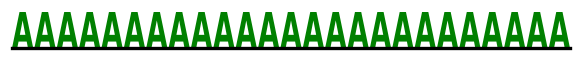

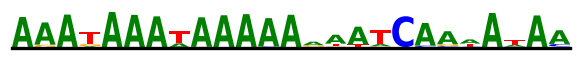

Test sequence 2:


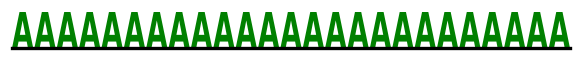

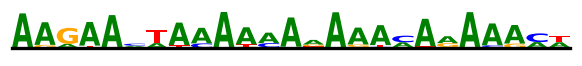

Test sequence 3:


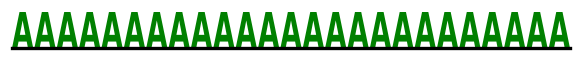

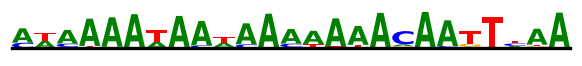

Test sequence 4:


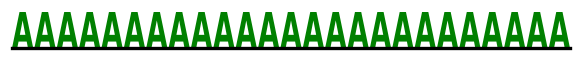

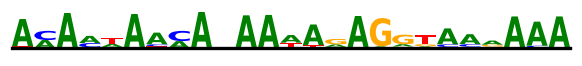

In [51]:
# Test sequences with stretches of As
x_a = np.zeros((32, 1, seq_length, 4))
x_a[:, :, :, 0] = 1.

# Run encoder
z_mean_test, z_log_var_test, z_test = encoder_model.predict([x_a], batch_size=32, verbose=True)
# Run decoder
s_test = np.zeros((x_a.shape[0], 1))
fake_pwm_test_batch = decoder_model.predict([s_test, z_test], batch_size=32, verbose=True)

# Plot a few sequences
for plot_i in range(5) :
    print("Test sequence " + str(plot_i) + ":")
    plot_pwm([x_a[plot_i, 0, :, :]])
    plot_pwm([fake_pwm_test_batch[1][plot_i, 0, :, :]])
    plt.show()

32/32 [==============================] - 0s 120us/step
Test sequence 0:


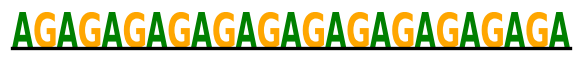

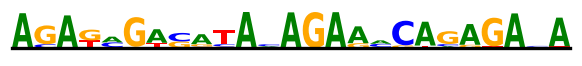

Test sequence 1:


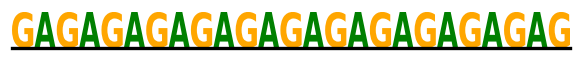

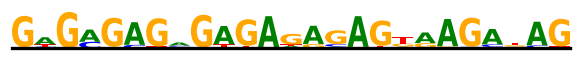

Test sequence 2:


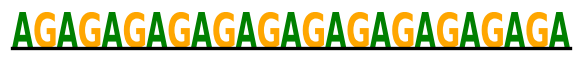

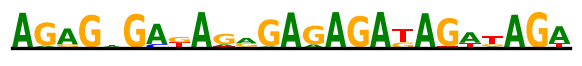

Test sequence 3:


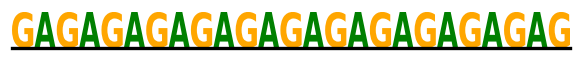

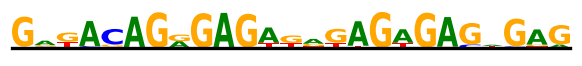

Test sequence 4:


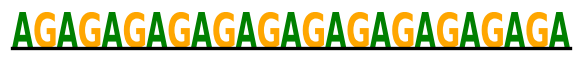

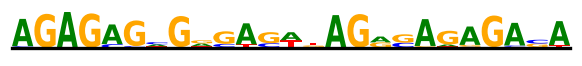

In [52]:
# Test sequences with stretches of AGs
x_ag = np.zeros((32, 1, seq_length, 4))
x_ag[0::2, :, 0::2, 0] = 1.
x_ag[0::2, :, 1::2, 2] = 1.
x_ag[1::2, :, 1::2, 0] = 1.
x_ag[1::2, :, 0::2, 2] = 1.

# Run encoder
z_mean_test, z_log_var_test, z_test = encoder_model.predict([x_ag], batch_size=32, verbose=True)
# Run decoder
s_test = np.zeros((x_ag.shape[0], 1))
fake_pwm_test_batch = decoder_model.predict([s_test, z_test], batch_size=32, verbose=True)

# Plot a few sequences
for plot_i in range(5) :
    print("Test sequence " + str(plot_i) + ":")
    plot_pwm([x_ag[plot_i, 0, :, :]])
    plot_pwm([fake_pwm_test_batch[1][plot_i, 0, :, :]])
    plt.show()

## Obtain log-likelihood distribution on training set

In [53]:
# Evaluate VAE Likelihood (ELBO) on supplied data
# Copied from genesis.vae

from scipy.stats import norm

def get_z_sample_numpy(z_mean, z_log_var, n_samples=1) :
    
    n = z_mean.shape[0]
    m = z_mean.shape[2]
    
    epsilon = np.random.normal(loc=0., scale=1., size=(n, n_samples, m))
    
    return z_mean + np.exp(0.5 * z_log_var) * epsilon


def evaluate_elbo(
        vae_encoder_model,
        vae_decoder_model,
        sequence_one_hots,
        pwm_start=0,
        pwm_end=-1,
        n_samples=1) :
    
    _epsilon = 10**-6
    
    if pwm_end == -1 :
        pwm_end = sequence_one_hots.shape[2]
    
    #Get sequence VAE encodings
    z_mean, z_log_var, _ = vae_encoder_model.predict(x=sequence_one_hots, batch_size=32, verbose=False)

    z_mean = np.tile(np.expand_dims(z_mean, axis=1), (1, n_samples, 1))
    z_log_var = np.tile(np.expand_dims(z_log_var, axis=1), (1, n_samples, 1))
    z = get_z_sample_numpy(z_mean, z_log_var, n_samples=n_samples)
    
    #Get re-decoded sequence PWMs
    s_dummy = np.zeros((sequence_one_hots.shape[0], 1))
    
    decoded_pwms = np.zeros((sequence_one_hots.shape[0], n_samples) + sequence_one_hots.shape[1:])

    for sample_ix in range(n_samples) :
        _, decoded_pwm, _ = vae_decoder_model.predict(x=[s_dummy, z[:, sample_ix, :]], batch_size=32, verbose=False)
        decoded_pwms[:, sample_ix, :, :, :] = decoded_pwm

    sequence_one_hots_expanded = np.tile(np.expand_dims(sequence_one_hots, 1), (1, n_samples, 1, 1, 1))
    
    #Calculate reconstruction log prob
    log_p_x_given_z = np.sum(np.sum(sequence_one_hots_expanded[:, :, :, pwm_start:pwm_end, :] * np.log(np.clip(decoded_pwms[:, :, :, pwm_start:pwm_end, :], _epsilon, 1. - _epsilon)) / np.log(10.), axis=(2, 4)), axis=2)

    #Calculate standard normal and importance log probs
    log_p_std_normal = np.sum(norm.logpdf(z, 0., 1.) / np.log(10.), axis=-1)
    log_p_importance = np.sum(norm.logpdf(z, z_mean, np.sqrt(np.exp(z_log_var))) / np.log(10.), axis=-1)

    #Calculate per-sample ELBO
    log_p_vae = log_p_x_given_z + log_p_std_normal - log_p_importance
    log_p_vae_div_n = log_p_vae - np.log(n_samples) / np.log(10.)

    #Calculate mean ELBO across samples (log-sum-exp trick)
    max_log_p_vae = np.max(log_p_vae_div_n, axis=-1)
    
    log_mean_p_vae = max_log_p_vae + np.log(np.sum(10**(log_p_vae_div_n - np.expand_dims(max_log_p_vae, axis=-1)), axis=-1)) / np.log(10.)
    mean_log_p_vae = np.mean(log_mean_p_vae)
    
    return log_mean_p_vae, mean_log_p_vae, log_p_vae

In [54]:
encoder = isolearn.keras.OneHotEncoder(seq_length=seq_length)

# Test dataset with high MRL
x_test_high = x_test

# Sample from full dataset
seqs_all = data.sample(x_test.shape[0], axis=0)['UTR'].values.tolist()
x_test_all = np.concatenate(
    [np.expand_dims(np.expand_dims(encoder(seq), axis=0), axis=0)
     for seq in seqs_all],
    axis=0,
)

In [55]:
# Generate random strings
import random

seqs_test_random = [
    ''.join(random.choice(['A', 'C', 'G', 'T']) for i in range(seq_length))
    for j in range(x_test.shape[0])
]
x_test_random = np.concatenate(
    [np.expand_dims(np.expand_dims(encoder(seq), axis=0), axis=0)
     for seq in seqs_test_random],
    axis=0,
)

Mean log likelihood for All data: -15.68
Mean log likelihood for High MRL, train: -15.32
Mean log likelihood for High MRL, test: -15.34
Mean log likelihood for Random seqs: -16.16


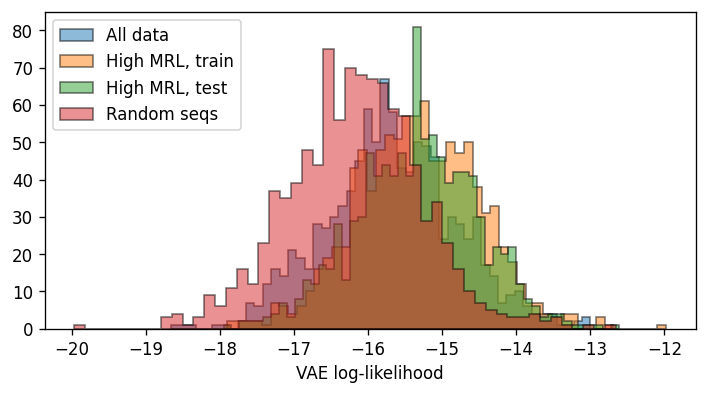

In [56]:
# Calculate and plot VAE log-likelihood

# log_mean_p_vae_test: (batch_size,)
# log_p_vae_test: (batch_size, n_samples)
x_test_datasets = [
    x_test_all,
    x_train[np.random.choice(len(x_train), size=x_test.shape[0], replace=False), :, :, :],
    x_test_high,
    x_test_random,
]
x_test_labels = [
    'All data',
    'High MRL, train',
    'High MRL, test',
    'Random seqs',
]


plt.figure(figsize=(7, 3.5))

for x_test_dataset, x_test_label in zip(x_test_datasets, x_test_labels):
    log_mean_p_vae, _, log_p_vae = evaluate_elbo(
        encoder_model,
        decoder_model,
        x_test_dataset,
        n_samples=128)
    print("Mean log likelihood for {}: {:.2f}".format(
        x_test_label,
        np.mean(log_mean_p_vae),
    ))

    plt.hist(
        log_mean_p_vae,
        bins=50,
        histtype='stepfilled',
        label=x_test_label,
        alpha=0.5,
        edgecolor=(0, 0, 0, 1),
    )

plt.xlabel("VAE log-likelihood")

plt.legend(loc='upper left')

In [57]:
# Generate synthetic data
x_test_a = np.zeros((x_test.shape[0], 1, seq_length, 4))
x_test_a[:, :, :, 0] = 1.

x_test_t = np.zeros((x_test.shape[0], 1, seq_length, 4))
x_test_t[:, :, :, 3] = 1.

x_test_ag = np.zeros((x_test.shape[0], 1, seq_length, 4))
x_test_ag[0::2, :, 0::2, 0] = 1.
x_test_ag[0::2, :, 1::2, 2] = 1.
x_test_ag[1::2, :, 1::2, 0] = 1.
x_test_ag[1::2, :, 0::2, 2] = 1.

Mean log likelihood for High MRL: -15.34
Mean log likelihood for T repeats: -13.82
Mean log likelihood for A repeats: -14.74
Mean log likelihood for AG repeats: -15.55


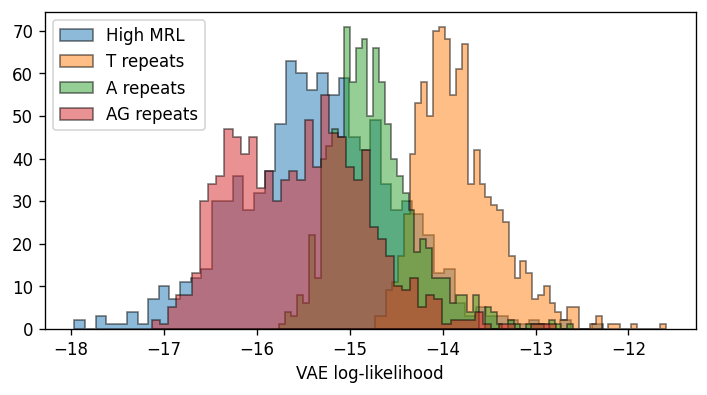

In [58]:
# Calculate and plot VAE log-likelihood

# log_mean_p_vae_test: (batch_size,)
# log_p_vae_test: (batch_size, n_samples)
x_test_datasets = [
    x_test_high,
    x_test_t,
    x_test_a,
    x_test_ag,
]
x_test_labels = [
    'High MRL',
    'T repeats',
    'A repeats',
    'AG repeats',
]


plt.figure(figsize=(7, 3.5))

for x_test_dataset, x_test_label in zip(x_test_datasets, x_test_labels):
    log_mean_p_vae, _, log_p_vae = evaluate_elbo(
        encoder_model,
        decoder_model,
        x_test_dataset,
        n_samples=128)
    print("Mean log likelihood for {}: {:.2f}".format(
        x_test_label,
        np.mean(log_mean_p_vae),
    ))

    plt.hist(
        log_mean_p_vae,
        bins=50,
        histtype='stepfilled',
        label=x_test_label,
        alpha=0.5,
        edgecolor=(0, 0, 0, 1),
    )

plt.xlabel("VAE log-likelihood")

plt.legend(loc='upper left')